In [4]:
import sys
import logging
import matplotlib.pyplot as plt
import cstrees.cstree as ct
import cstrees.scoring as sc
import cstrees.stage as st
import cstrees.learning as ctl
import networkx as nx
import numpy as np
%load_ext autoreload
%autoreload 2
#logging.basicConfig(stream=sys.stderr, level=logging.DEBUG)
logging.basicConfig(stream=sys.stderr, level=logging.ERROR)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


      a  b  c
0     2  2  2
1     1  0  1
2     1  0  0
3     1  0  0
4     0  0  0
...  .. .. ..
4996  1  0  0
4997  1  0  0
4998  0  0  0
4999  1  0  0
5000  1  0  0

[5001 rows x 3 columns]


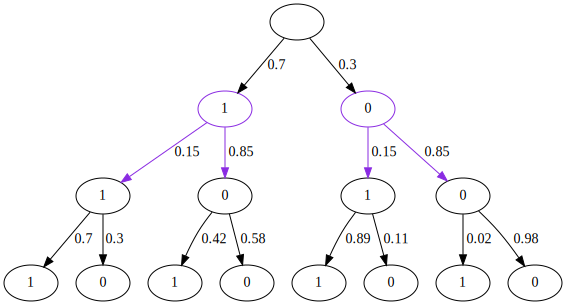

In [5]:
np.random.seed(6)
tree = ct.CStree([2] * 3, labels=["a", "b", "c"])

# V-structure
tree.update_stages({
    0: [st.Stage([{0, 1}])],
    1: [st.Stage([0, 0]), st.Stage([0, 1]), st.Stage([1, 0]), st.Stage([1, 1])]})

tree.sample_stage_parameters(alpha=1.0)

a = tree.plot()

# a.draw("testplot.png")
x = tree.sample(5000)
print(x)

true_cdags = tree.to_minimal_context_graphs()
for key, val in true_cdags.items():
    agraph = nx.nx_agraph.to_agraph(val)
    agraph.layout("dot")
    agraph.draw("testing/"+str(key) + "_true.png",
                args='-Glabel="'+str(key)+'"   ')
a


In [6]:

order = ["a", "b", "c"]
# Should order be expressed as the labels or as the levels?
# labels seems more natural but may include strings then which is a bit ugly.

# This is the order of the data columns.
s1 = sc.score_order(order, x, max_cvars=2, alpha_tot=1.0, method="BDeu")
print(s1)


-7767.510194306091


In [7]:
#order = [0, 2, 1]
order = ["a", "c", "b"]  # We know that b should not be to the very right.
s2 = sc.score_order(order, x, max_cvars=2, alpha_tot=1.0, method="BDeu")
print(s2)


-7771.847348603729


order: ['a', 'b', 'c'], score: -7767.510194306091
order: ['a', 'c', 'b'], score: -7771.847348603729
order: ['b', 'a', 'c'], score: -7767.510194306091
order: ['b', 'c', 'a'], score: -7771.84734860373
order: ['c', 'a', 'b'], score: -7771.847348603729
order: ['c', 'b', 'a'], score: -7771.847348603728
optimal order: ['a', 'b', 'c'], score -7767.510194306091
stages :{0: [<cstrees.stage.Stage object at 0x7fd0a3e92e00>], 1: [<cstrees.stage.Stage object at 0x7fd0a3d70d90>, <cstrees.stage.Stage object at 0x7fd0a3d71510>, <cstrees.stage.Stage object at 0x7fd0a3d712d0>, <cstrees.stage.Stage object at 0x7fd0a3d72290>], 2: [], -1: [<cstrees.stage.Stage object at 0x7fd0e3c757b0>]}

Optimal CStree stagings per level:
level 0:
[{0, 1}]
level 1:
[0, 0]
[1, 0]
[0, 1]
[1, 1]
level 2:


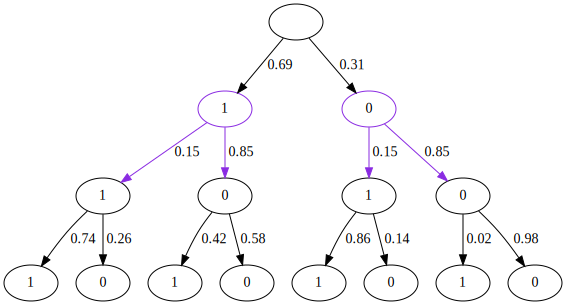

In [8]:
optord, score = ctl.find_optimal_order(
    x, strategy="max", max_cvars=2, alpha_tot=1.0, method="BDeu")
print("optimal order: {}, score {}".format(optord, score))

opttree = ctl.optimal_cstree_given_order(optord, x, max_cvars=2,
                             alpha_tot=1.0, method="BDeu")
print("stages :{}".format(opttree.stages))

print("\nOptimal CStree stagings per level:")
for key, val in opttree.stages.items():
    if key == -1:
        continue
    print("level {}:".format(key))
    for val2 in val:
        print(val2)
opttree.estimate_stage_parameters(x, alpha_tot=1.0, method="BDeu")
opttree.plot()


In [ ]:
opt_cdags = opttree.to_minimal_context_graphs()
for key, val in opt_cdags.items():
    agraph = nx.nx_agraph.to_agraph(val)
    agraph.layout("dot")
    agraph.draw("testing/"+str(key) + "_opt.png",
                args='-Glabel="'+str(key)+'"   ')
